# Coding With Me: Tensorflow
## Step 1: Hello World
<img src="./hello.PNG" alt="Hello TensorFlow!" width="200">
Let's validate the environment by the above "hello" graph:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import input_data

In [2]:
import tensorflow as tf
words = tf.constant('Hello, TensorFlow')
feel = tf.constant('!')
hello = tf.add(words, feel)
sess = tf.Session()
writer = tf.train.SummaryWriter("/root/compute/log", sess.graph)
print(sess.run(hello))
print(sess.run(feel))

Hello, TensorFlow!
!


## Step 2: Getting familar, a simple linear model

In TensorFlow, data models (e.g. CNNs)/loss functions (e.g. square loss)/optimizations (e.g. SGD) are converted to graphs, by which the computation is performed. The general steps are as following:
* Construct the model and draw the graph;
* Implement the graph in TensorFlow;
* Init variables and run/evaluate the graph in the TensorFlow session;
* (Optional) Display the graph in TensorBoard.

Let's mock some data from a linear model:
$y = 2.1x + 0.1$

In [3]:
x = np.random.rand(100, 1).astype("float32")
y = 2.1 *  x + 0.1

Let's add some Guassian noise and plot:

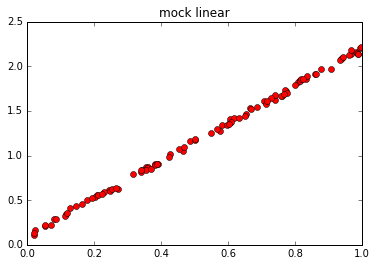

In [4]:
noise = np.random.normal(0, 0.02, (100, 1))
y = y + noise
plt.plot(x, y, 'ro')
plt.title("mock linear")

Construct the model:

In [5]:
x_ = tf.placeholder(tf.float32, [None, 1])
y_ = tf.placeholder(tf.float32, [None, 1])
w = tf.Variable(tf.zeros([1,1]))
b = tf.Variable(tf.zeros([1,1]))
predict = x_ * w + b

Define loss function (mean square) and optimize:

In [6]:
loss = tf.reduce_mean(tf.square(y_ - predict))
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

Run the graph, training for $w$ and $b$:
<img src="./linear.PNG" alt="A Simple Linear Model" width="200">

In [7]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
writer = tf.train.SummaryWriter("/root/compute/log", sess.graph)

for i in range(501):
    sess.run(train, feed_dict={x_: x, y_: y})
    if i % 50 == 0:
        print i, sess.run(w), sess.run(b)

0 [[ 0.84636843]] [[ 1.23393321]]
50 [[ 2.05557251]] [[ 0.12983824]]
100 [[ 2.10046673]] [[ 0.10397118]]
150 [[ 2.10192132]] [[ 0.1031331]]
200 [[ 2.10196853]] [[ 0.1031059]]
250 [[ 2.10196877]] [[ 0.10310566]]
300 [[ 2.10196877]] [[ 0.10310566]]
350 [[ 2.10196877]] [[ 0.10310566]]
400 [[ 2.10196877]] [[ 0.10310566]]
450 [[ 2.10196877]] [[ 0.10310566]]
500 [[ 2.10196877]] [[ 0.10310566]]


## Step 3: Working on MNIST

MNIST data reader API:
* datasets = read_data_sets(path, fake_data, one_hot)
* dataset.next_batch(number_samples, fake_data)
* dataset.images
Let's see an example from MNIST

Extracting ../repo/MNIST/train-images-idx3-ubyte.gz
Extracting ../repo/MNIST/train-labels-idx1-ubyte.gz
Extracting ../repo/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../repo/MNIST/t10k-labels-idx1-ubyte.gz


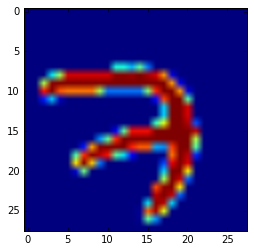

In [11]:
mnist = input_data.read_data_sets("../repo/MNIST", one_hot = True)
imgs = mnist.train.images
img = imgs[0].reshape(28, 28)
plt.imshow(img)

### 3.1 Softmax

In [12]:
sess = tf.Session()

x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])
w = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# softmax model
y = tf.nn.softmax(tf.matmul(x, w) + b)

# train
loss = -tf.reduce_sum(y_*tf.log(y))
train = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

sess.run(tf.initialize_all_variables())
for i in range(1000):
	batch = mnist.train.next_batch(50)
	sess.run(train, feed_dict={x: batch[0], y_: batch[1]})
    
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y,1), tf.argmax(y_,1)), "float"))

writer = tf.train.SummaryWriter("/root/compute/log", sess.graph)

print sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})

0.9092


### 3.2 CNN

The feature is automatically learned through multiple layers.

In [13]:
def weight_variable(shape):
	initial = tf.truncated_normal(shape, stddev=0.1)
	return tf.Variable(initial)

def bias_variable(shape):
	initial = tf.constant(0.1, shape = shape)
	return tf.Variable(initial)

def conv2d(x, W):
	return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
	return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [14]:
# model
x = tf.placeholder("float", shape=[None, 784])
# convert to a stack of images
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [15]:
# conv1
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# max-pool1
h_pool1 = max_pool_2x2(h_conv1)

# conv2
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

# max-pool1
h_pool2 = max_pool_2x2(h_conv2)

# dense
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# train
y_ = tf.placeholder("float", shape=[None, 10])
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess = tf.Session()
sess.run(tf.initialize_all_variables())
for i in range(2000):
	batch = mnist.train.next_batch(50)
  	if i%100 == 0:
		train_accuracy = sess.run(accuracy, feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
		print("step %d, training accuracy %g"%(i, train_accuracy))
	sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

# test
#print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
batch = mnist.test.next_batch(500)
print("test accuracy %g"%sess.run(accuracy, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0}))


step 0, training accuracy 0.08
step 100, training accuracy 0.88
step 200, training accuracy 0.94
step 300, training accuracy 0.92
step 400, training accuracy 0.94
step 500, training accuracy 0.96
step 600, training accuracy 0.96
step 700, training accuracy 0.96
step 800, training accuracy 1
step 900, training accuracy 0.92
step 1000, training accuracy 1
step 1100, training accuracy 0.96
step 1200, training accuracy 1
step 1300, training accuracy 0.96
step 1400, training accuracy 1
step 1500, training accuracy 0.96
step 1600, training accuracy 0.96
step 1700, training accuracy 0.98
step 1800, training accuracy 1
step 1900, training accuracy 1
test accuracy 0.98
